In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3 import Model
import theano.tensor as tt
import arviz as az
from python_models import *
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_rows = 20


In [2]:
df = pd.read_csv('data/apixiban_regression_data.csv')
yobs = df.Concentration_scaled.values
times = df.Time.values
subjectids = pd.Categorical(df.Subject).codes
subjects = np.unique(subjectids)

covars = df.drop_duplicates(subset = 'Subject').loc[:,['Sex','Age','Creatinine','Weight']]
covars['Sex'] = pd.Categorical(covars.Sex).codes
X = covars.values
X[:, 1:] = StandardScaler().fit_transform(X[:,1:])

X.shape

(36, 4)

In [31]:
with WeakModel(yobs, times, subjectids):
    prior = pm.sample_prior_predictive(100)
    trace = pm.sample(tune=1, draws=1, chains=1)
    weak_model_data = az.from_pymc3(prior=prior, trace=trace)
#     trace = pm.sample(tune=1000, draws=1000, chains=12)
#     posterior = pm.sample_posterior_predictive(trace)
    
#     weak_model_data = az.from_pymc3(prior = prior,
#                          trace = trace,
#                          posterior_predictive=posterior,
#                          coords = {'subject':subjects},
#                          dims={'CL': ['subject'],
#                               'ke':['subject'],
#                               'ka': ['subject'],
#                               'tmax':['subject']})

Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, delay, kappa, phi, alpha, z_t, s_t, mu_t, z_CL, s_CL, mu_CL]
Sampling chain 0, 0 divergences: 100%|██████████| 2/2 [00:00<00:00,  7.89it/s]
/Users/demetri/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain contains only diverging samples. The model is probably misspecified.


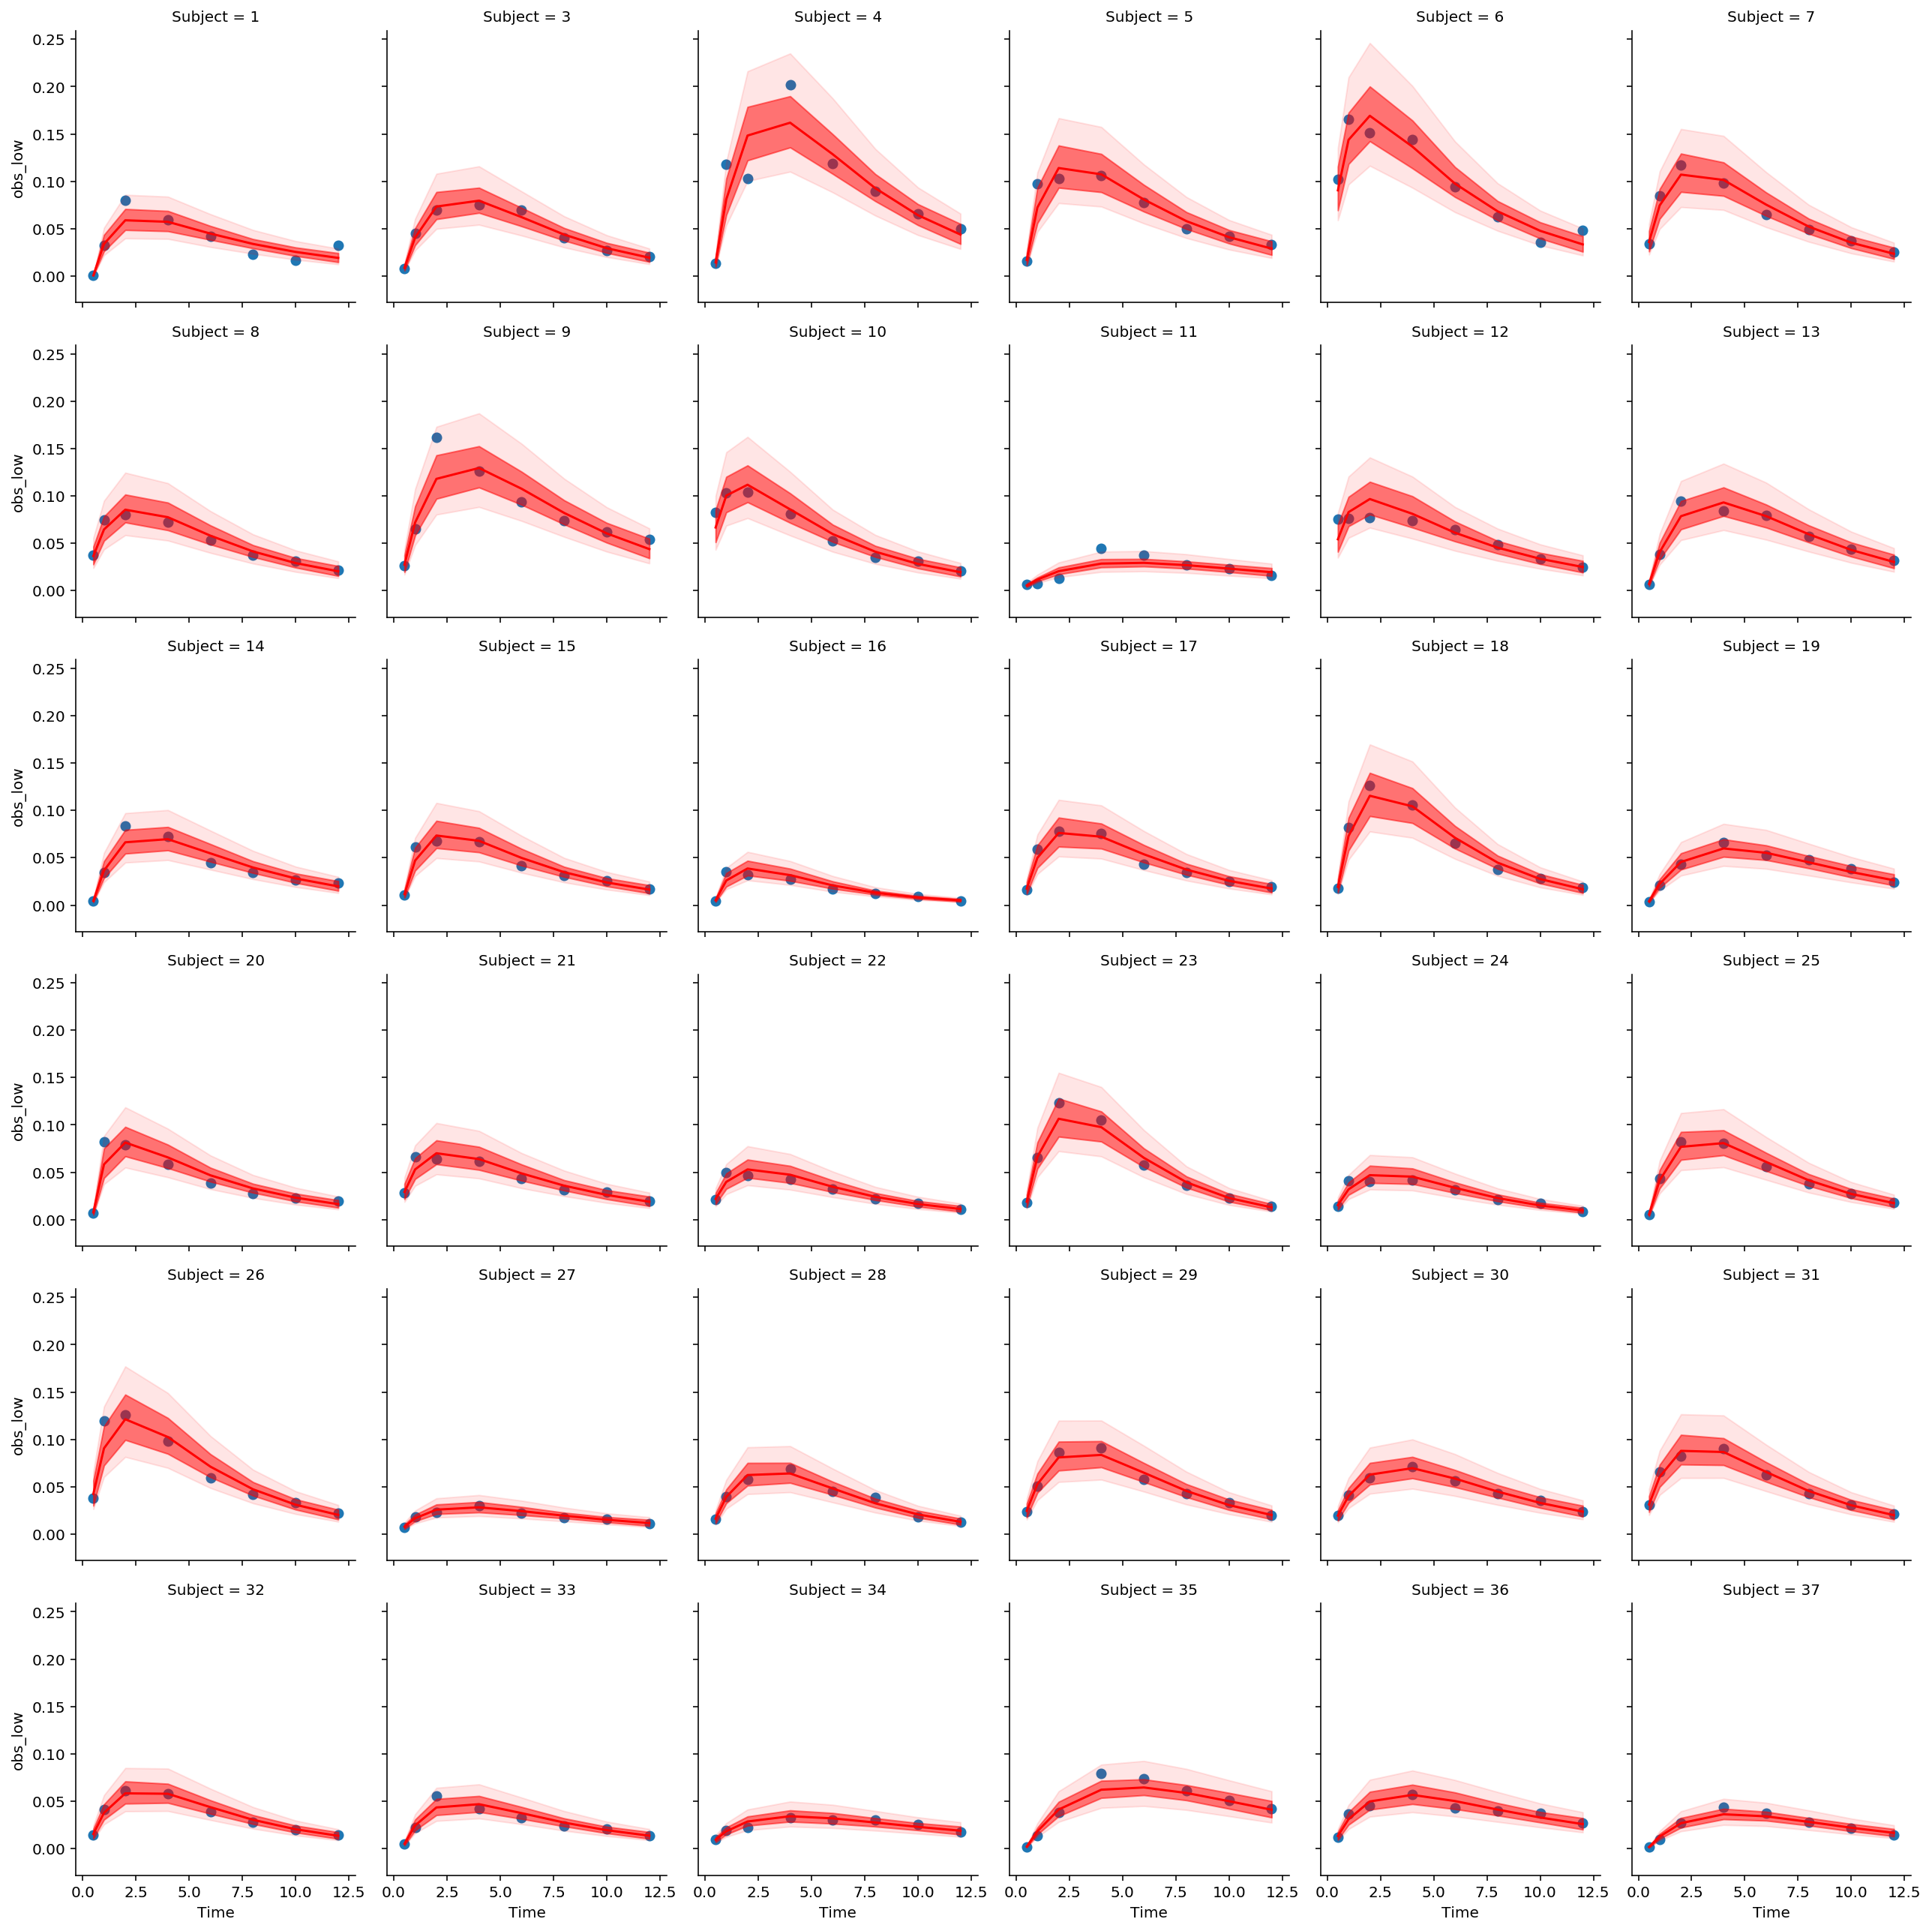

In [4]:
df['predictions'] = weak_model_data.posterior.ypred.mean(axis = (0,1)).values
df['predictions_low'] = np.quantile(weak_model_data.posterior.ypred, 0.025, axis = (0,1))
df['predictions_high'] = np.quantile(weak_model_data.posterior.ypred, 0.975, axis = (0,1))

df['obs_low'] = np.quantile(weak_model_data.posterior_predictive.y, 0.025, axis = (0,1))
df['obs_high'] = np.quantile(weak_model_data.posterior_predictive.y, 0.975, axis = (0,1))

g = sns.FacetGrid(df, col='Subject', col_wrap=6)

g.map(plt.scatter, 'Time','Concentration_scaled')
g.map(plt.plot, 'Time','predictions', color = 'red')
g.map(plt.fill_between, 'Time','predictions_low', 'predictions_high', color = 'red', alpha = 0.5)
g.map(plt.fill_between, 'Time','obs_low', 'obs_high', color = 'red', alpha = 0.1)

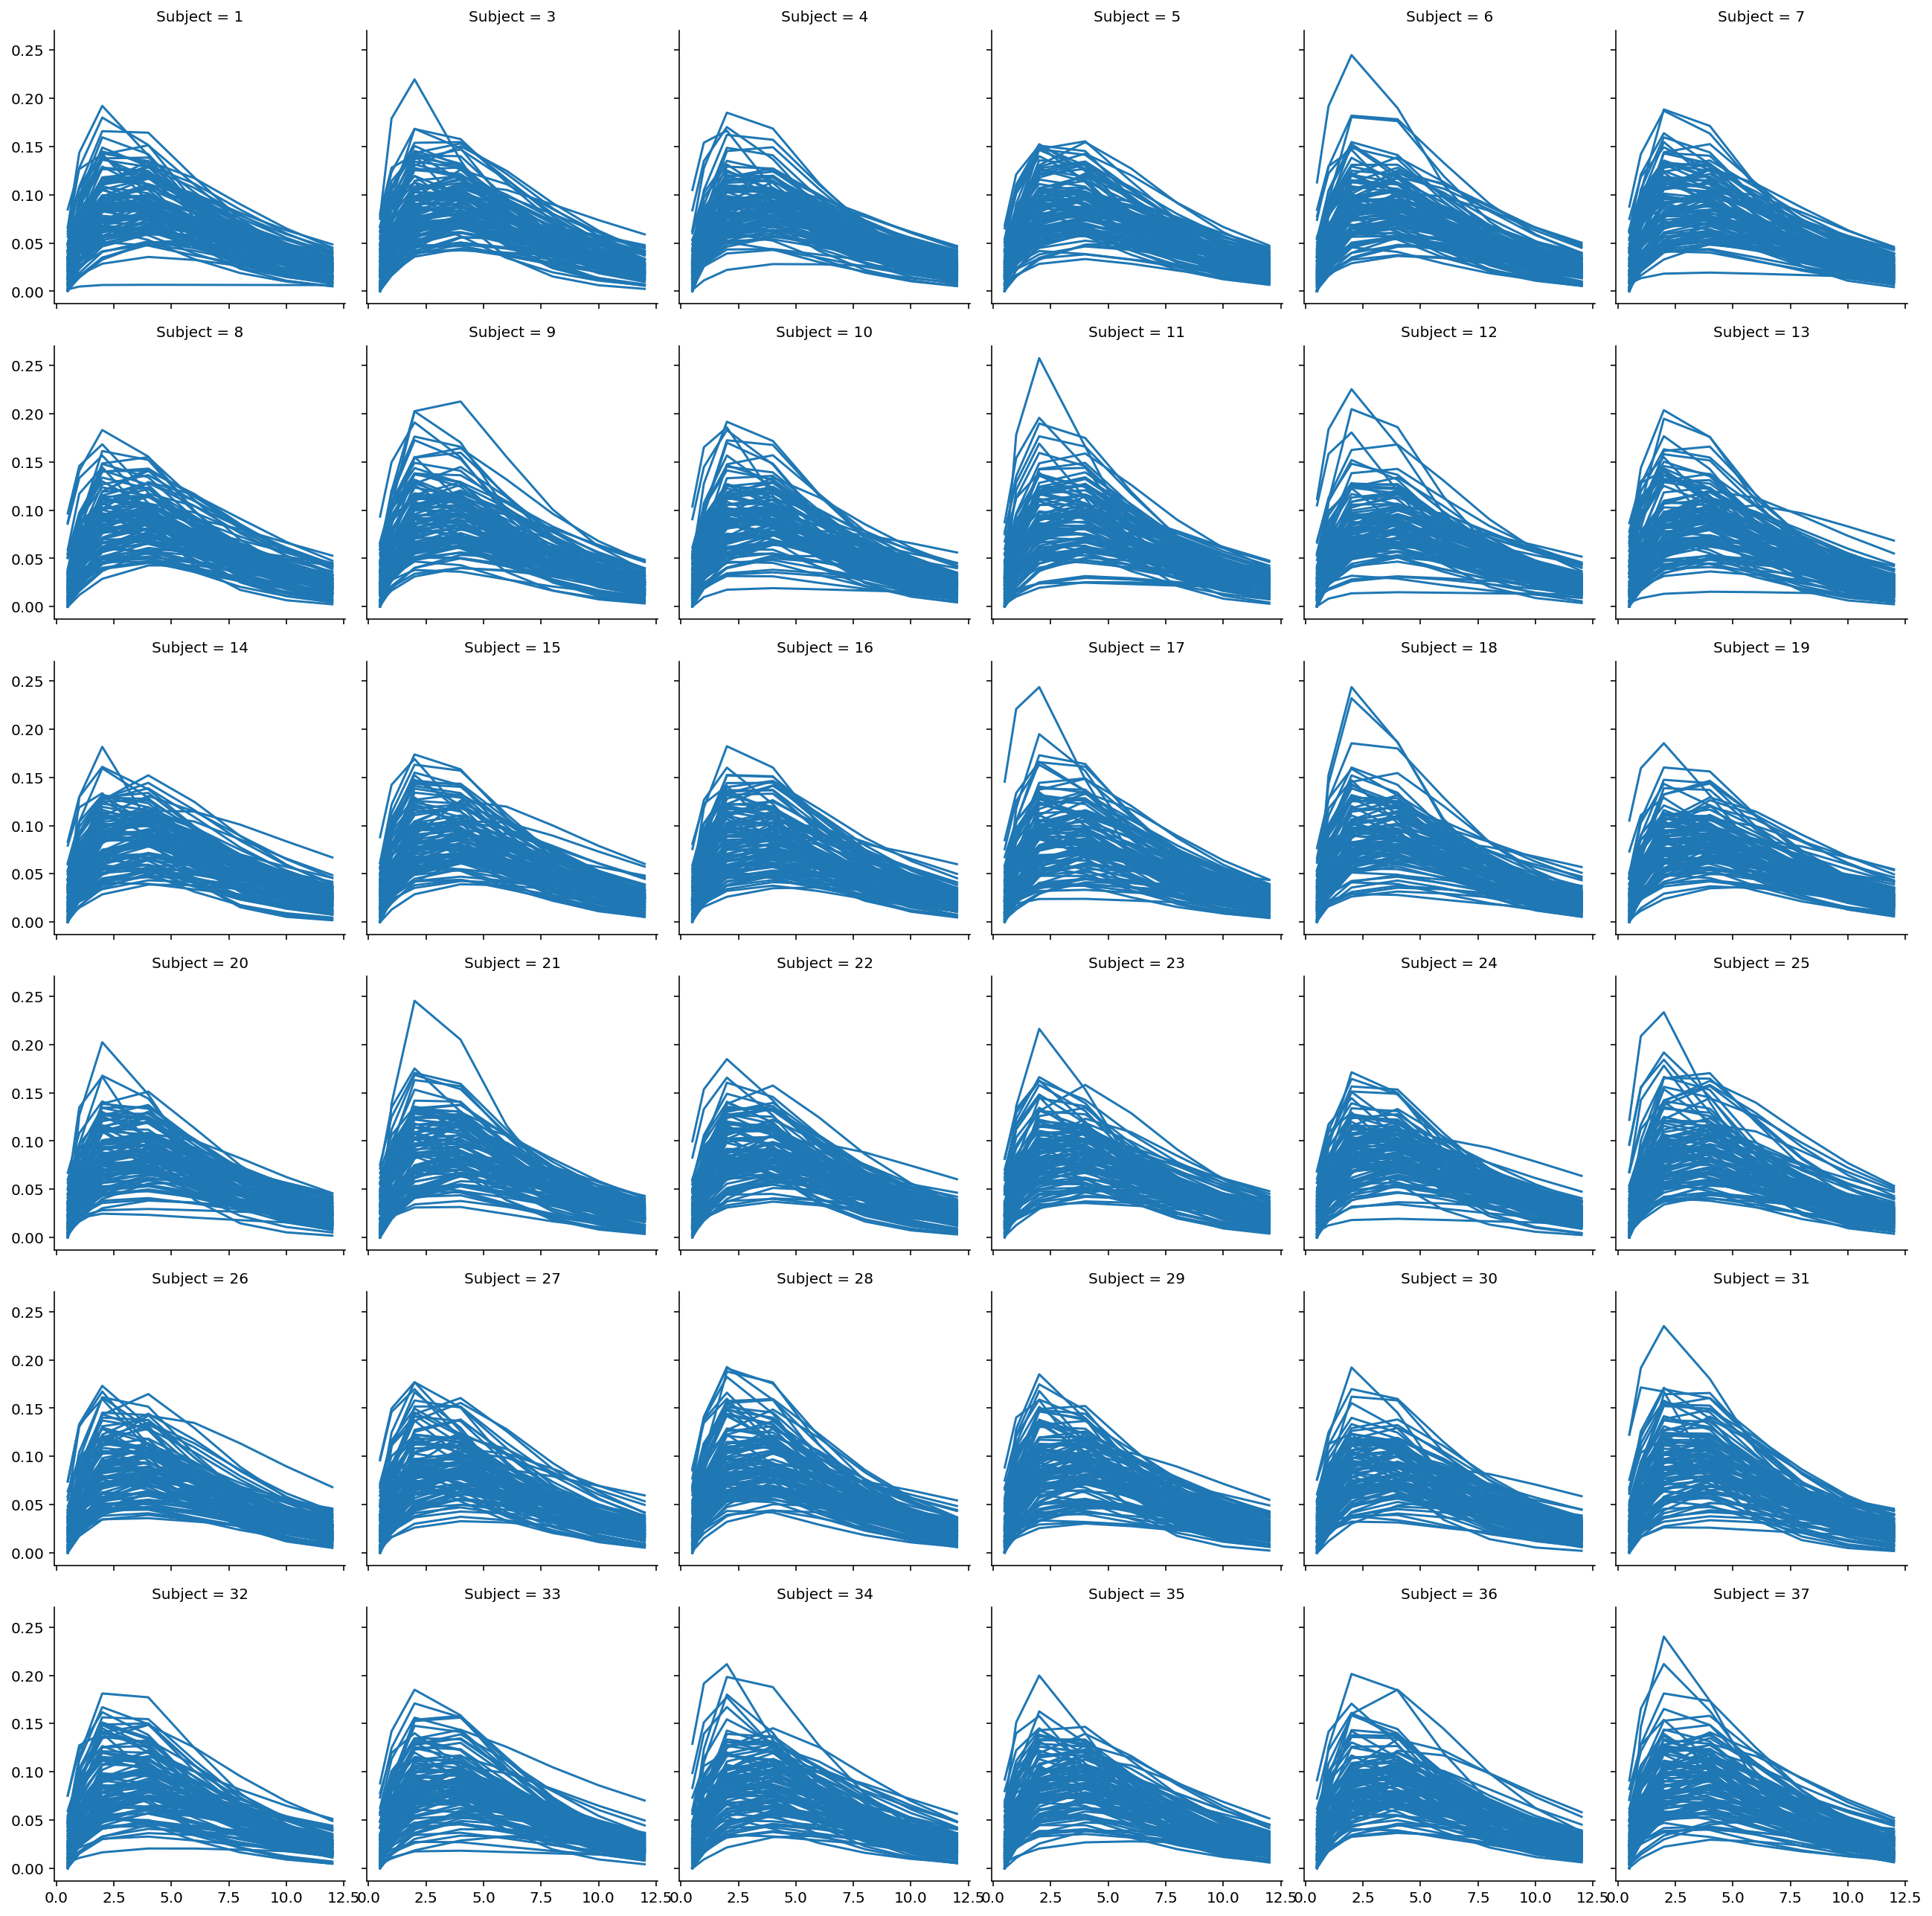

In [37]:
prior = weak_model_data.prior.ypred.to_dataframe().reset_index(level=[0], drop=True).reset_index(level=0)

samples = df.loc[:, ['Time','Subject']].merge(prior, how = 'left', left_index=True, right_index=True)

g = sns.FacetGrid(samples, col='Subject', col_wrap=6)

g.map_dataframe(sns.lineplot, x='Time',y='ypred', estimator=None, units='draw')

___

In [5]:
condition, no_condition = make_new_subjects(100)


times = condition.times.values
subjects = np.unique(condition.subjectids)
subjectids = condition.subjectids.values

test_times = no_condition.times.values
test_subjectids = no_condition.subjectids.values


In [6]:
with StrongModel(None, times, subjectids, test_times, test_subjectids, use_delay=False) as tmaxmodel:
    
    prior = pm.sample_prior_predictive(1)

In [7]:
condition['y'] = prior['ypred']
yobs = prior['y']
no_condition['y'] = prior['y_oos']

In [14]:
sample = False

with StrongModel(yobs, times, subjectids, test_times, test_subjectids, use_delay=False) as tmaxmodel:
    
    maps = pm.find_MAP()
    if sample:
        prior = pm.sample_prior_predictive()
        trace = pm.sample(tune=1000, draws=1000, chains=4)
        posterior = pm.sample_posterior_predictive(trace)

        data = az.from_pymc3(prior = prior,
                             trace = trace,
                             posterior_predictive=posterior,
                             coords = {'subject':subjects},
                             dims={'CL': ['subject'],
                                  'ke':['subject'],
                                  'ka': ['subject'],
                                  'tmax':['subject']})

logp = 2,905.9, ||grad|| = 1,552.2: 100%|██████████| 16/16 [00:00<00:00, 1206.26it/s]  
